In [9]:
import skimage
import numpy as np
import torch
import torch.nn as nn
from torch import cuda, optim, tensor, zeros_like
from torch import device as torch_device
from torch.nn import L1Loss, MSELoss
from matplotlib import pyplot as plt


from darts.common_utils import *
from darts.phantom import generate_phantom, phantom_to_torch
from darts.noises import add_selected_noise
from darts.early_stop import EarlyStop, MSE, MAE


# base

In [11]:


model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',
                       in_channels=1, out_channels=1, init_features=64, pretrained=False)

dtype = cuda.FloatTensor
buffer_size = 100
patience = 1000
lr = 0.001
num_iter = 3000
resolution=8
device = torch_device('cuda' if cuda.is_available() else "cpu")
noise_type = 'gaussian'

raw_img_np = generate_phantom(resolution=resolution) # 64x64 np array
img_np = raw_img_np.reshape(1, raw_img_np.shape[0], raw_img_np.shape[1]) # 1x64x64 np array
img_np = np.repeat(img_np, 3, axis=0) # 3x64x64 np array
img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min())
img_torch = phantom_to_torch(raw_img_np).unsqueeze(0) # 1x3x64x64 torch tensor
img_noisy_torch = add_selected_noise(img_torch, noise_type=noise_type,noise_factor=0.15) # 1x3x64x64 torch tensor
img_noisy_np = img_noisy_torch.squeeze(0).numpy() # 3x64x64 np array
raw_img_noisy_np = np.mean(img_noisy_np, axis=0) # 64x64 np array
img_noisy_torch = img_noisy_torch.to(device)


Using cache found in C:\Users\thesis/.cache\torch\hub\mateuszbuda_brain-segmentation-pytorch_master


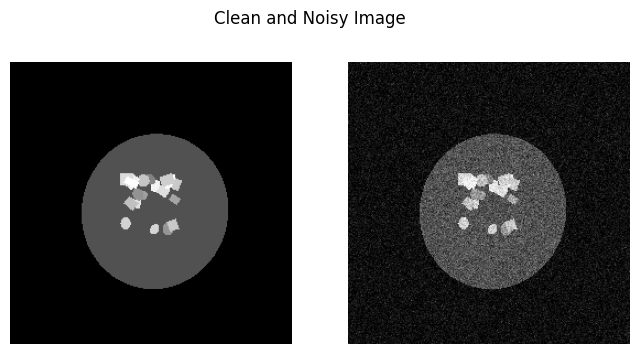

C:\Users\thesis\AppData\Local\Temp\ipykernel_39104\3255267677.py:44: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  psnr = skimage.metrics.peak_signal_noise_ratio(img_np, r_img_np)


Iteration 00000    Loss 0.1444    PSNR 7.6107    SSIM 0.0233


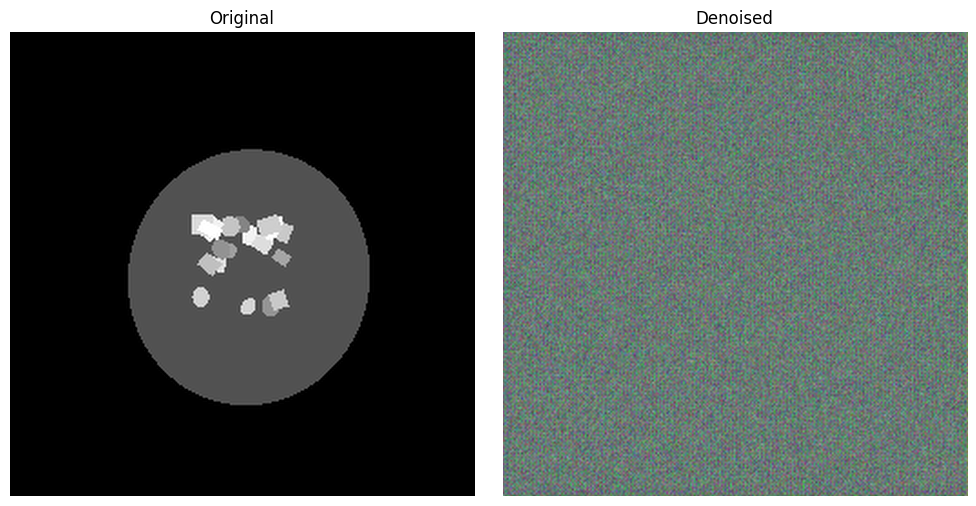

Iteration 00500    Loss 0.0102    PSNR 23.9968    SSIM 0.1348


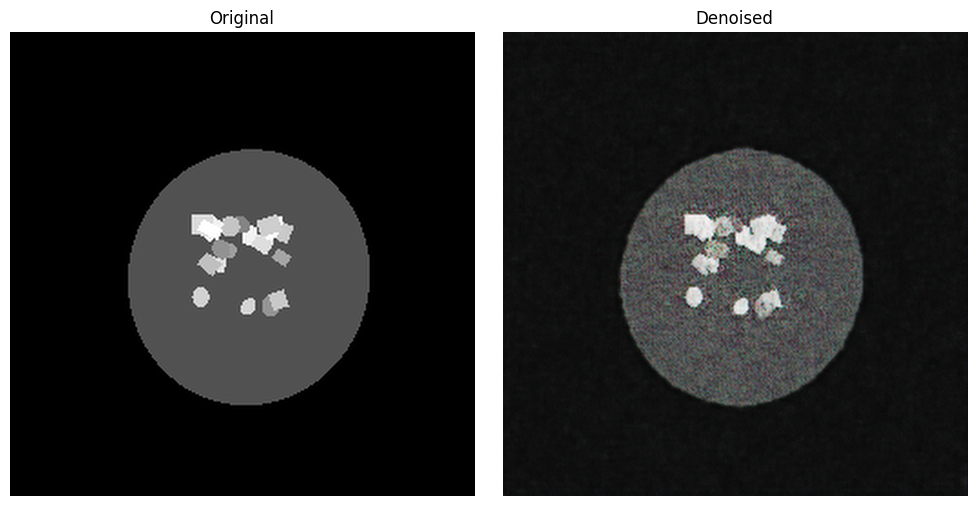

Iteration 01000    Loss 0.0012    PSNR 19.0628    SSIM 0.0670


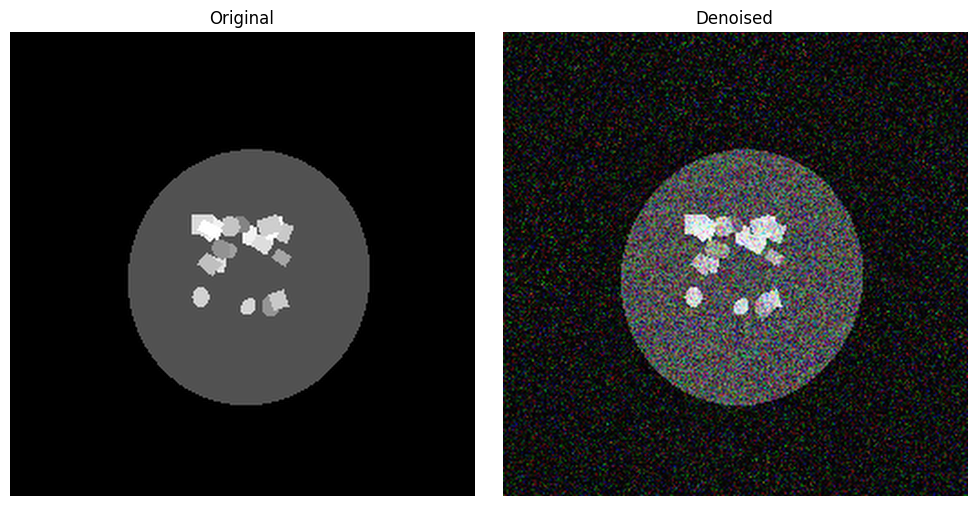

Iteration 01500    Loss 0.0002    PSNR 18.7114    SSIM 0.0661


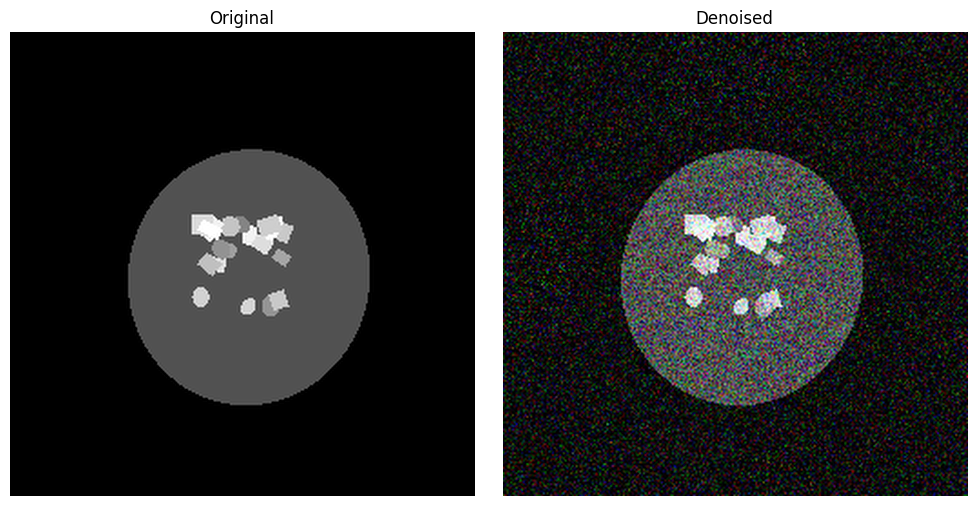

Iteration 02000    Loss 0.0001    PSNR 18.6882    SSIM 0.0660


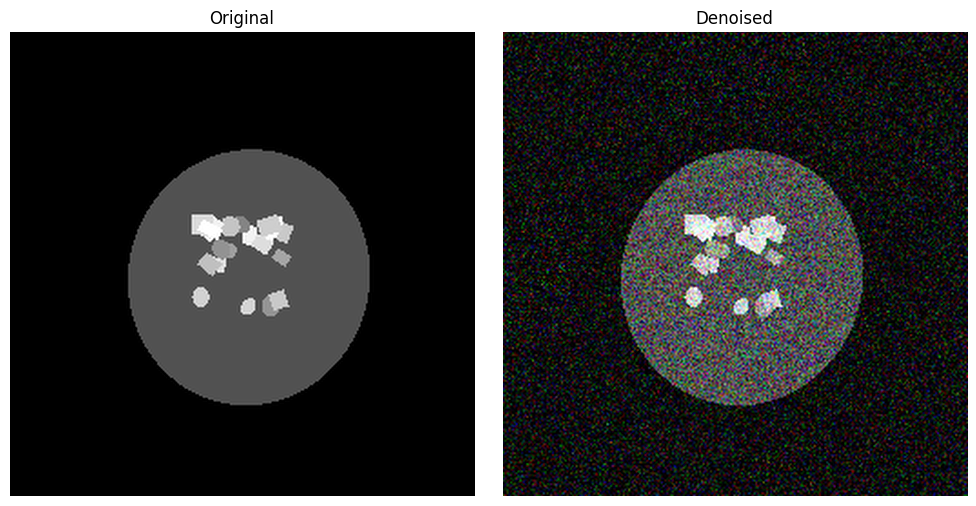

Iteration 02500    Loss 0.0114    PSNR 24.9444    SSIM 0.2395


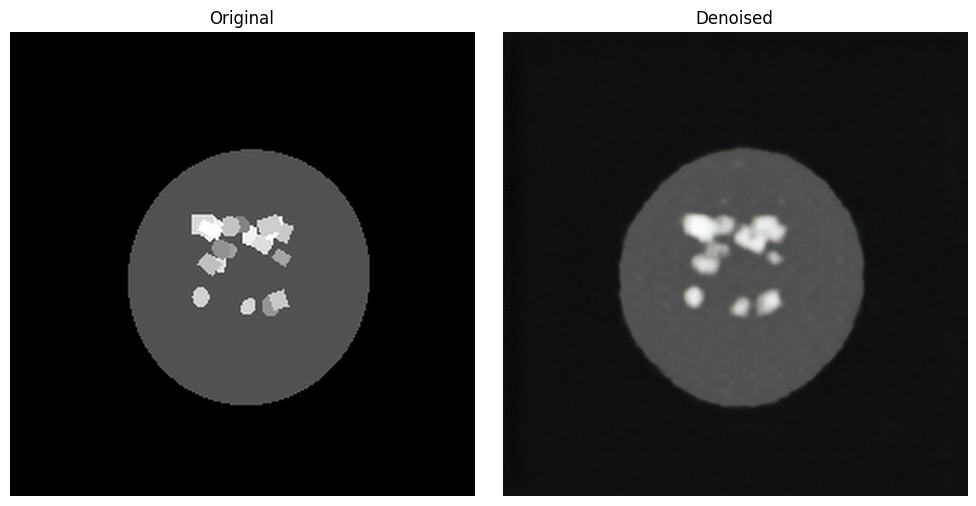

In [12]:

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
fig.suptitle('Clean and Noisy Image')
ax1.imshow(raw_img_np, cmap='gray')
ax2.imshow(raw_img_noisy_np, cmap='gray')
ax1.axis('off')
ax2.axis('off')
plt.show()
plt.close()

net_input = get_noise(input_depth=3, spatial_size=raw_img_np.shape[1], noise_type=noise_type).type(dtype).to(device)

# Add synthetic noise
net = model.to(device)
net = net.type(dtype)

# Loss
criterion = MSELoss().type(dtype).to(device)

# Optimizer
p = get_params('net', net, net_input)  # network parameters to be optimized
optimizer = optim.Adam(p, lr=lr)

# Optimize

# reg_noise_std = 1./30. 
reg_noise_std = tensor(1./30.).type(dtype).to(device)
show_every = 500
loss_history = []
psnr_history = []
ssim_history = []
variance_history = []
x_axis = []
earlystop = EarlyStop(size=buffer_size,patience=patience)
def closure(iterator):
    #DIP
    net_input_perturbed = net_input + zeros_like(net_input).normal_(std=reg_noise_std)
    r_img_torch = net(net_input_perturbed)
    total_loss = criterion(r_img_torch, img_noisy_torch)
    total_loss.backward()
    loss_history.append(total_loss.item())
    if iterator % show_every == 0:
        # evaluate recovered image (PSNR, SSIM)
        r_img_np = torch_to_np(r_img_torch)
        psnr = skimage.metrics.peak_signal_noise_ratio(img_np, r_img_np)
        temp_img_np = np.transpose(img_np,(1,2,0))
        temp_r_img_np = np.transpose(r_img_np,(1,2,0))
        data_range = temp_img_np.max() - temp_img_np.min()
        ssim = skimage.metrics.structural_similarity(temp_img_np, temp_r_img_np, multichannel=True, win_size=7, channel_axis=-1, data_range=data_range)
        psnr_history.append(psnr)
        ssim_history.append(ssim)
        print(f'Iteration %05d    Loss %.4f' % (iterator, total_loss.item()) + '    PSNR %.4f' % (psnr) + '    SSIM %.4f' % (ssim))

        #variance hisotry
        r_img_np = r_img_np.reshape(-1)
        earlystop.update_img_collection(r_img_np)
        img_collection = earlystop.get_img_collection()
        if len(img_collection) == buffer_size:
            ave_img = np.mean(img_collection,axis = 0)
            variance = []
            for tmp in img_collection:
                variance.append(MSE(ave_img, tmp))
            cur_var = np.mean(variance)
            cur_epoch = iterator
            variance_history.append(cur_var)
            x_axis.append(cur_epoch)
            if earlystop.stop == False:
                earlystop.stop = earlystop.check_stop(cur_var, cur_epoch)
    return total_loss
    
for iterator in range(num_iter):
    optimizer.zero_grad()
    closure(iterator)
    optimizer.step()
    
    if iterator % show_every == 0:
        r_img_np = torch_to_np(net(net_input))
        # plot_image_grid([np.clip(img_np, 0, 1), np.clip(r_img_np, 0, 1)], factor=1, nrow=1)
        plot_side_by_side(np.clip(img_np, 0, 1), np.clip(r_img_np, 0, 1))
        
